In [ ]:
import artem_chubov as model
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import time
from PIL import Image


In [2]:
image_foreground = Image.open(r"C:\Users\ARteem\Desktop\face.png").convert("L")
image_foreground.save(r"C:\Users\ARteem\Desktop\output_image.png")

In [46]:
def get_samples(image_path_foreground, image_path_background, h, w, H, W, num_samples, std, seed = 94):

    np.random.seed(seed)

    image_background = Image.open(image_path_background).convert("L")
    image_background_resized = image_background.resize((W, H))
    background_array = np.array(image_background_resized)

    image_foreground = Image.open(image_path_foreground).convert("L")
    image_foreground_resized = image_foreground.resize((w, h))
    foreground_array = np.array(image_foreground_resized)
    foreground_mask = (foreground_array != 96).astype(np.float64) 
    
    noisy_samples = np.zeros([H, W, num_samples])

    for i in range(num_samples):
        
        sample = background_array.copy()

        max_x = H - foreground_array.shape[0]
        max_y = W - foreground_array.shape[1]
        x_offset = np.random.randint(0, max_x)
        y_offset = np.random.randint(0, max_y)

        x_slice = slice(x_offset, x_offset + foreground_array.shape[0])
        y_slice = slice(y_offset, y_offset + foreground_array.shape[1])

        sample[x_slice, y_slice] = (
            sample[x_slice, y_slice] * (1 - foreground_mask)  
            + foreground_array * foreground_mask  
        )
    
        noise = np.random.normal(0, std, sample.shape)
        noisy_image = sample + noise
        
        noisy_samples[..., i] = noisy_image


    return noisy_samples


h, w, H, W = 16, 16, 20, 30

image_path_foreground = r"C:\Users\ARteem\Desktop\face.png"
image_path_background = r"C:\Users\ARteem\Desktop\background.jpg"

image_background = Image.open(r"C:\Users\ARteem\Desktop\background.jpg").convert("L")
image_background_resized = image_background.resize((W, H))
B = np.array(image_background_resized)

image_foreground = Image.open(image_path_foreground).convert("L")
image_foreground_resized = image_foreground.resize((w, h))
foreground_array = np.array(image_foreground_resized)
F = (foreground_array != 96).astype(np.float64) 

num_samples = 500
std = 200

noisy_samples = get_samples(image_path_foreground, image_path_background, h, w, H, W, num_samples, std = std)


- # Сравнение инициализаций:

In [4]:
from scipy.ndimage import gaussian_filter


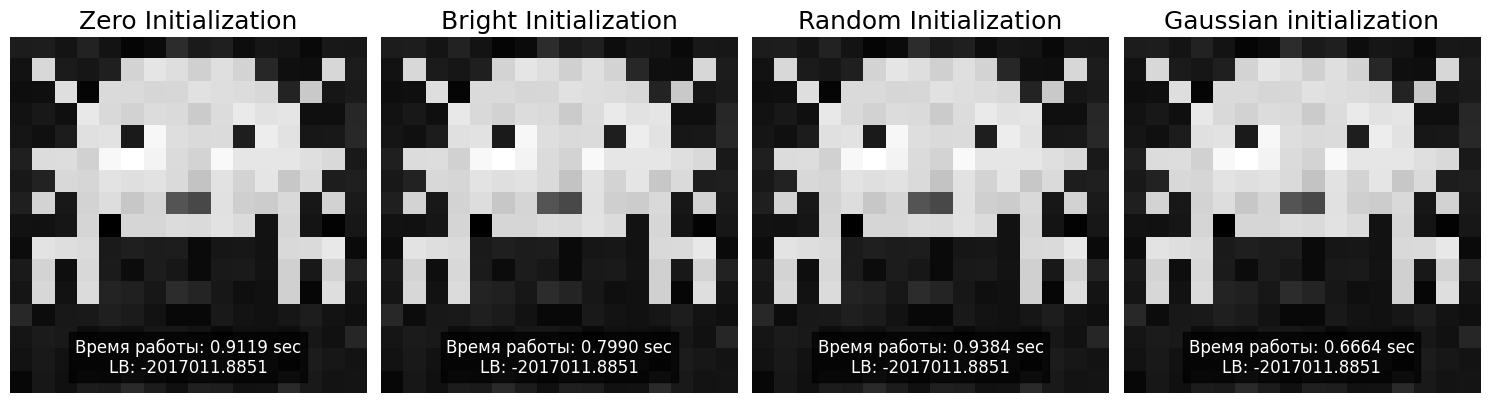

In [ ]:
np.random.seed(42)

F_zero = np.full((h, w), 0)
B_zero = np.full((H, W), 0)
s_zero = 1e-2
A_zero = np.full((H - h + 1, W - w + 1), 1e-7)
A_zero /= A_zero.sum()

F_255 = np.full((h, w), 255)
B_255 = np.full((H, W), 255)
A_255 = np.full((H - h + 1, W - w + 1), 1e-7)
A_255 /= A_255.sum()


F_med = noisy_samples[..., np.random.choice(num_samples)]
B_med = noisy_samples[..., np.random.choice(num_samples)]

x = gaussian_filter(F_med, 1/((H-h)*(W-w))*np.std(noisy_samples, axis = (0,1)).mean())
F_med = x[:h, :w]
B_med = gaussian_filter(B_med, np.std(noisy_samples, axis = (0,1)).mean())
s_med = 1
A_med = np.full((H - h + 1, W - w + 1), 1.)
A_med /= A_med.sum()

F_rand = np.random.randint(0, 256, size=(h, w))
B_rand = np.random.randint(0, 256, size=(H, W))
s_rand = np.random.exponential(0.1)
A_rand = np.full((H - h + 1, W - w + 1), 1e-7)
A_rand /= A_rand.sum()

start_time = time.time()
F_pred_zero, B_pred_zero, s_pred_zero, A_pred_zero, LL_pred_zero = model.run_EM(
    noisy_samples.astype(np.float64), h, w, use_MAP=False, max_iter=50, 
    s = s_zero, F = F_zero, B = B_zero, A = A_zero)
time_zero = time.time() - start_time
time_zero_str = f"Время работы: {time_zero:.4f} sec"
LL_zero_str = f"LB: {LL_pred_zero[-1]:.4f}"

start_time = time.time()
F_pred_255, B_pred_255, s_pred_255, A_pred_255, LL_pred_255 = model.run_EM(
    noisy_samples.astype(np.float64), h, w, use_MAP=False, max_iter=50, 
    s = s_zero, F = F_255, B = B_255, A = A_255)
time_255 = time.time() - start_time
time_255_str = f"Время работы: {time_255:.4f} sec"
LL_255_str = f"LB: {LL_pred_255[-1]:.4f}"

start_time = time.time()
F_pred_mean, B_pred_mean, s_pred_mean, A_pred_mean, LL_pred_mean = model.run_EM(
    noisy_samples, h, w, use_MAP=False, max_iter=50, 
    s = s_med, F = F_med, B = B_med, A = A_med)
time_mean = time.time() - start_time
time_mean_str = f"Время работы: {time_mean:.4f} sec"
LL_mean_str = f"LB: {LL_pred_mean[-1]:.4f}"

start_time = time.time()
F_pred_rand, B_pred_rand, s_pred_rand, A_pred_rand, LL_pred_rand = model.run_EM(
    noisy_samples, h, w, use_MAP=False, max_iter=50, 
    s = s_rand, F = F_rand, B = B_rand, A = A_rand)
time_rand = time.time() - start_time
time_rand_str = f"Время работы: {time_rand:.4f} sec"
LL_rand_str = f"LB: {LL_pred_rand[-1]:.4f}"

fig, axs = plt.subplots(1, 4, figsize=(15, 10))

axs[0].imshow(F_pred_zero, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Zero Initialization',fontsize = 18)
axs[0].text(0.5, 0.1, f'{time_zero_str}\n{LL_zero_str}', ha='center', va='center', transform=axs[0].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

axs[1].imshow(F_pred_255, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Bright Initialization',fontsize = 18)
axs[1].text(0.5, 0.1, f'{time_255_str}\n{LL_255_str}', ha='center', va='center', transform=axs[1].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

axs[3].imshow(F_pred_mean, cmap='gray')
axs[3].axis('off')
axs[3].set_title('Gaussian initialization', fontsize = 18)
axs[3].text(0.5, 0.1, f'{time_mean_str}\n{LL_mean_str}', ha='center', va='center', transform=axs[3].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

axs[2].imshow(F_pred_rand, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Random Initialization', fontsize = 18)
axs[2].text(0.5, 0.1, f'{time_rand_str}\n{LL_rand_str}', ha='center', va='center', transform=axs[2].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()


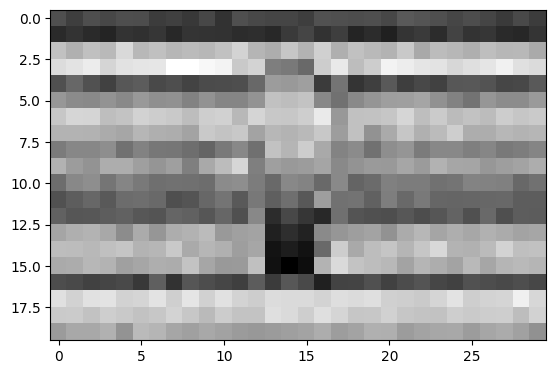

In [27]:
plt.imshow(B_pred_mean, cmap = 'gray')

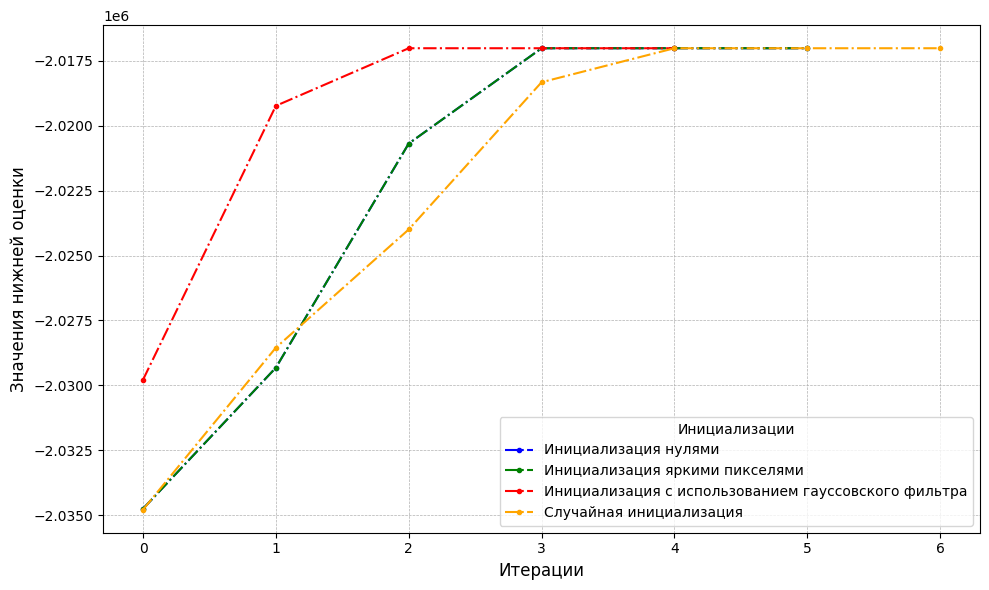

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(LL_pred_zero, label='Инициализация нулями', color='blue', linestyle='-.', marker='o', markersize=3)
plt.plot(LL_pred_255, label='Инициализация яркими пикселями', color='green', linestyle='-.', marker='o', markersize=3)
plt.plot(LL_pred_mean, label='Инициализация с использованием гауссовского фильтра', color='red', linestyle='-.', marker='o', markersize=3)
plt.plot(LL_pred_rand, label='Случайная инициализация', color='orange', linestyle='-.', marker='o', markersize=3)

plt.xlabel('Итерации', fontsize=12)
plt.ylabel('Значения нижней оценки', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Инициализации', loc='best', fontsize=10)

plt.tight_layout()
plt.show()

- # Сравнение размеров выборок и силы зашумления:

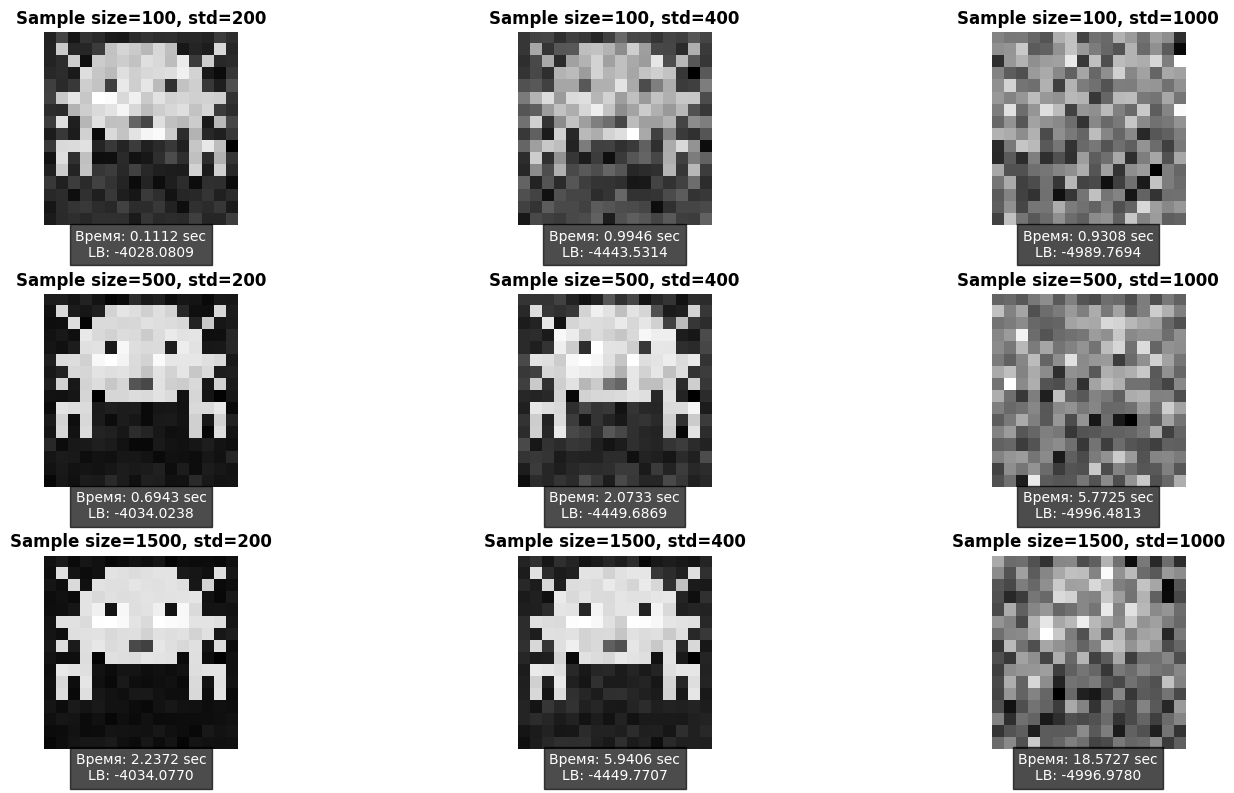

In [47]:
def run_experiments(foreground, background, h, w, H, W, num_samples_list, std_list, F, B):
    
    fig, axs = plt.subplots(len(num_samples_list), len(std_list), figsize=(16, 8), sharex='all', sharey='all')
    lb_data = {}

    norm_differences_F = {}
    norm_differences_B = {}

    for i, num_samples in enumerate(num_samples_list):
        for j, std in enumerate(std_list):
            noisy_samples = get_samples(foreground, background, h, w, H, W, num_samples, std)
            np.random.seed(42)

            F_zero = np.full((h, w), 0)
            B_zero = np.full((H, W), 0)
            s_zero = 1e-2
            A_zero = np.full((H - h + 1, W - w + 1), 1e-7)
            A_zero /= A_zero.sum()

            start_time = time.time()
            F_pred, B_pred, s_pred_zero, A_pred_zero, LL_pred = model.run_EM(
                noisy_samples.astype(np.float64), h, w, use_MAP=False, max_iter=50,
                s=s_zero, F=F_zero, B=B_zero, A=A_zero)
            time_taken = time.time() - start_time

            lb_data[(num_samples, std)] = LL_pred/num_samples
            norm_differences_F[(num_samples, std)] = np.linalg.norm(F_pred - F)
            norm_differences_B[(num_samples, std)] = np.linalg.norm(B_pred - B)

            time_str = f"Время: {time_taken:.4f} sec"
            LL_str = f"LB: {LL_pred[-1]/num_samples:.4f}"

            ax = axs[i, j]  
            ax.imshow(F_pred, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Sample size={num_samples}, std={std}', fontsize=12, fontweight='bold')

            ax.text(0.5, -0.1, f'{time_str}\n{LL_str}', ha='center', va='center', transform=ax.transAxes,
                    fontsize=10, color='white', bbox=dict(facecolor='black', alpha=0.7))

    plt.subplots_adjust(hspace=0.4, wspace=0.4)  
    plt.tight_layout()  
    
    plt.show()

    return lb_data, norm_differences_F, norm_differences_B

num_samples_list = [100, 500, 1500]
std_list = [200, 400, 1000]

lb_std_ns, F_std_ns, B_std_ns = run_experiments(image_path_foreground, image_path_background, h, w, H, W, num_samples_list, std_list, F, B)


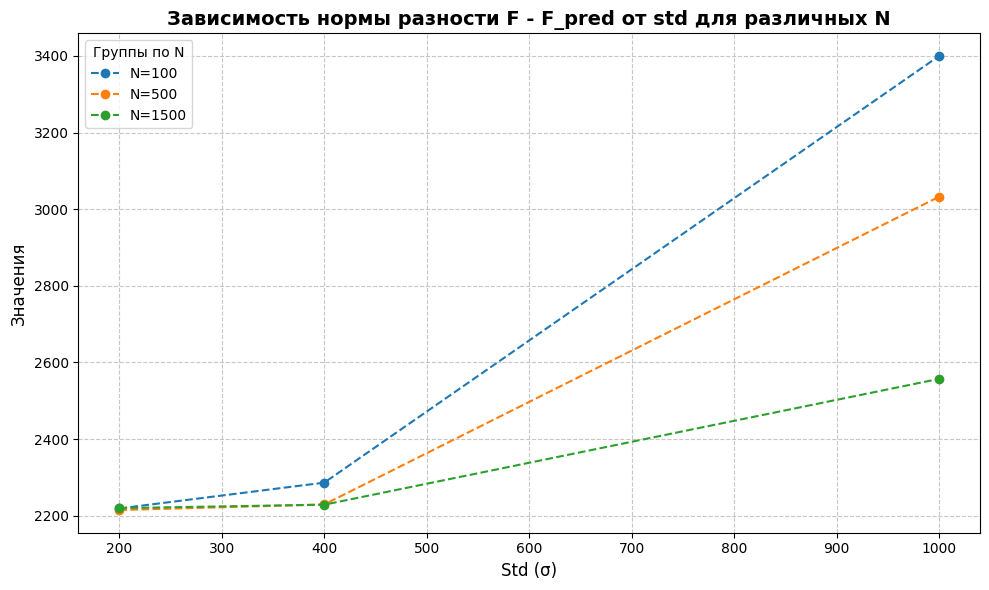

In [55]:
grouped_data = {}
for (n, std), value in F_std_ns.items():
    if n not in grouped_data:
        grouped_data[n] = []
    grouped_data[n].append((std, value))

plt.figure(figsize=(10, 6))

for n, values in grouped_data.items():
    values = sorted(values)
    stds, vals = zip(*values)  
    plt.plot(stds, vals, label=f'N={n}', marker='o', linestyle='--')

plt.title('Зависимость нормы разности F - F_pred от std для различных N', fontsize=14, fontweight='bold')
plt.xlabel('Std (σ)', fontsize=12)
plt.ylabel('Значения', fontsize=12)
plt.legend(title='Группы по N', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

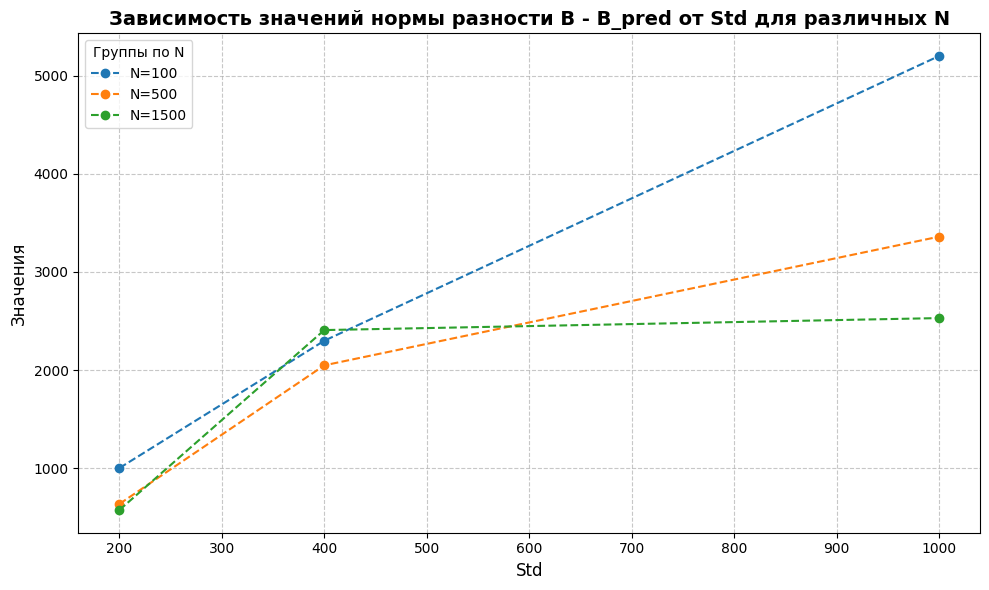

In [ ]:
grouped_data = {}
for (n, std), value in B_std_ns.items():
    if n not in grouped_data:
        grouped_data[n] = []
    grouped_data[n].append((std, value))

plt.figure(figsize=(10, 6))

for n, values in grouped_data.items():
    values = sorted(values)
    stds, vals = zip(*values) 
    plt.plot(stds, vals, label=f'N={n}', marker='o', linestyle='--')


plt.title('Зависимость значений нормы разности B - B_pred от std для различных N', fontsize=14, fontweight='bold')
plt.xlabel('Std', fontsize=12)
plt.ylabel('Значения', fontsize=12)
plt.legend(title='Группы по N', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

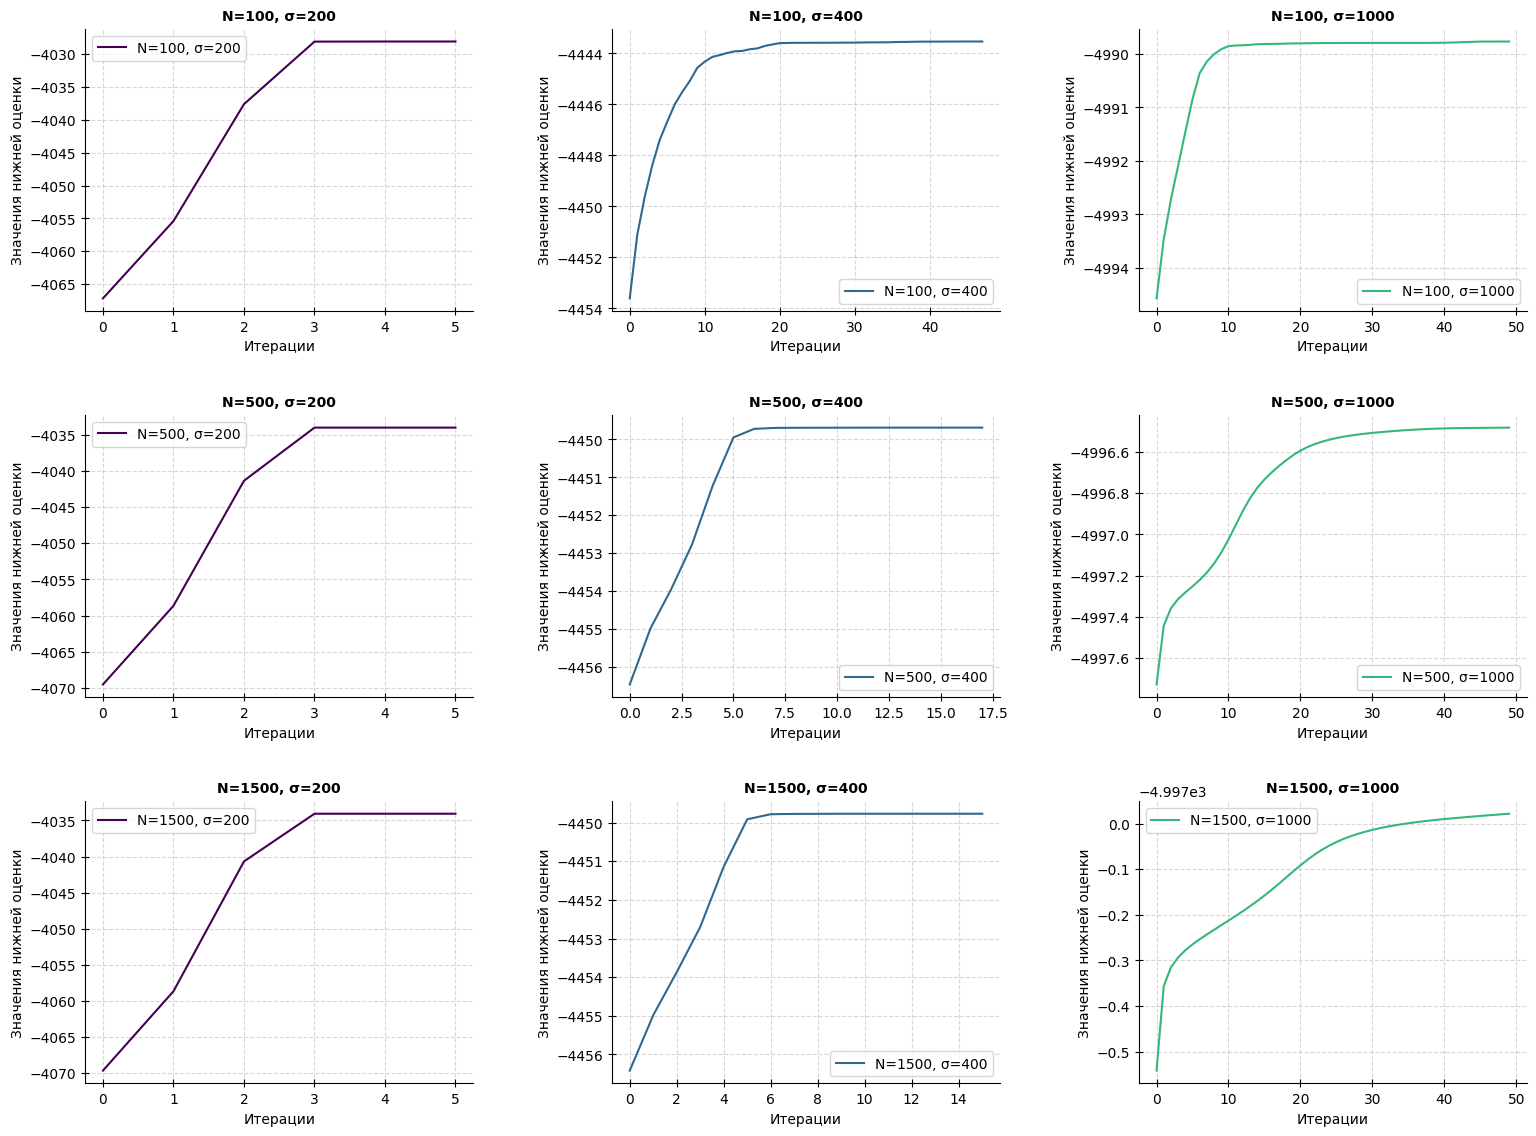

In [ ]:
unique_ns = sorted(set(num_samples for num_samples, _ in lb_std_ns.keys()))
unique_stds = sorted(set(std for _, std in lb_std_ns.keys()))

fig, axs = plt.subplots(len(unique_ns), len(unique_stds), figsize=(16, 12))

for i, num_samples in enumerate(unique_ns):
    for j, std in enumerate(unique_stds):
        ax = axs[i, j]  
        ll_values = lb_std_ns.get((num_samples, std), None)

        if ll_values is not None:
            ax.plot(np.arange(len(ll_values)), ll_values, label=f'N={num_samples}, σ={std}', 
                    linestyle='-', color=plt.cm.viridis(j / len(unique_stds)))  
            ax.set_title(f'N={num_samples}, σ={std}', fontsize=10, fontweight='bold', color='black')
            ax.set_xlabel('Итерации', fontsize=10)
            ax.set_ylabel('Значения нижней оценки', fontsize=10)
            
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend(fontsize=10)
            
            ax.tick_params(axis='both', labelsize=10, direction='inout', length=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

fig.tight_layout(pad=3.0)

plt.show()

- # Тесты для мапа

In [39]:
start_time = time.time()
F_pred_zero_map, B_pred_zero_map, s_pred_zero_map, A_pred_zero_map, LL_pred_zero_map = model.run_EM(
    noisy_samples.astype(np.float64), h, w, use_MAP=True, max_iter=50, 
    s = s_zero, F = F_zero, B = B_zero, A = A_zero)
time_zero_map = time.time() - start_time
time_zero_map_str = f"Время работы: {time_zero_map:.4f} sec"
LL_zero_map_str = f"LL: {LL_pred_zero_map[-1]:.4f}"

start_time = time.time()
F_pred_255_map, B_pred_255_map, s_pred_255_map, A_pred_255_map, LL_pred_255_map = model.run_EM(
    noisy_samples.astype(np.float64), h, w, use_MAP=True, max_iter=50, 
    s = s_zero, F = F_255, B = B_255, A = A_255)
time_255_map = time.time() - start_time
time_255_map_str = f"Время работы: {time_255_map:.4f} sec"
LL_255_map_str = f"LL: {LL_pred_255_map[-1]:.4f}"

start_time = time.time()
F_pred_mean_map, B_pred_mean_map, s_pred_mean_map, A_pred_mean_map, LL_pred_mean_map = model.run_EM(
    noisy_samples, h, w, use_MAP=True, max_iter=50, 
    s = s_med, F = F_med, B = B_med, A = A_med)
time_mean_map = time.time() - start_time
time_mean_map_str = f"Время работы: {time_mean_map:.4f} sec"
LL_mean_map_str = f"LL: {LL_pred_mean_map[-1]:.4f}"

start_time = time.time()
F_pred_rand_map, B_pred_rand_map, s_pred_rand_map, A_pred_rand_map, LL_pred_rand_map = model.run_EM(
    noisy_samples, h, w, use_MAP=True, max_iter=50, 
    s = s_rand, F = F_rand, B = B_rand, A = A_rand)
time_rand_map = time.time() - start_time
time_rand_map_str = f"Время работы: {time_rand_map:.4f} sec"
LL_rand_map_str = f"LL: {LL_pred_rand_map[-1]:.4f}"


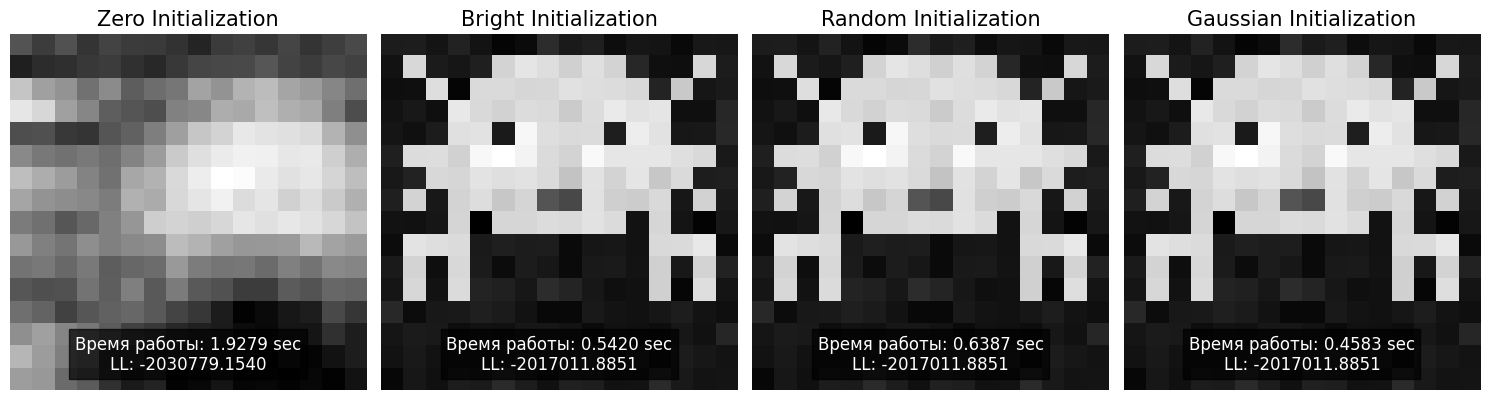

In [42]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))

axs[0].imshow(F_pred_zero_map, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Zero Initialization', fontsize=15)
axs[0].text(0.5, 0.1, f'{time_zero_map_str}\n{LL_zero_map_str}', ha='center', va='center', transform=axs[0].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

axs[1].imshow(F_pred_255_map, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Bright Initialization', fontsize=15)
axs[1].text(0.5, 0.1, f'{time_255_map_str}\n{LL_255_map_str}', ha='center', va='center', transform=axs[1].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

axs[2].imshow(F_pred_rand_map, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Random Initialization', fontsize=15)
axs[2].text(0.5, 0.1, f'{time_rand_map_str}\n{LL_rand_map_str}', ha='center', va='center', transform=axs[2].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

axs[3].imshow(F_pred_mean_map, cmap='gray')
axs[3].axis('off')
axs[3].set_title('Gaussian Initialization', fontsize=15)
axs[3].text(0.5, 0.1, f'{time_mean_map_str}\n{LL_mean_map_str}', ha='center', va='center', transform=axs[3].transAxes, 
               fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()


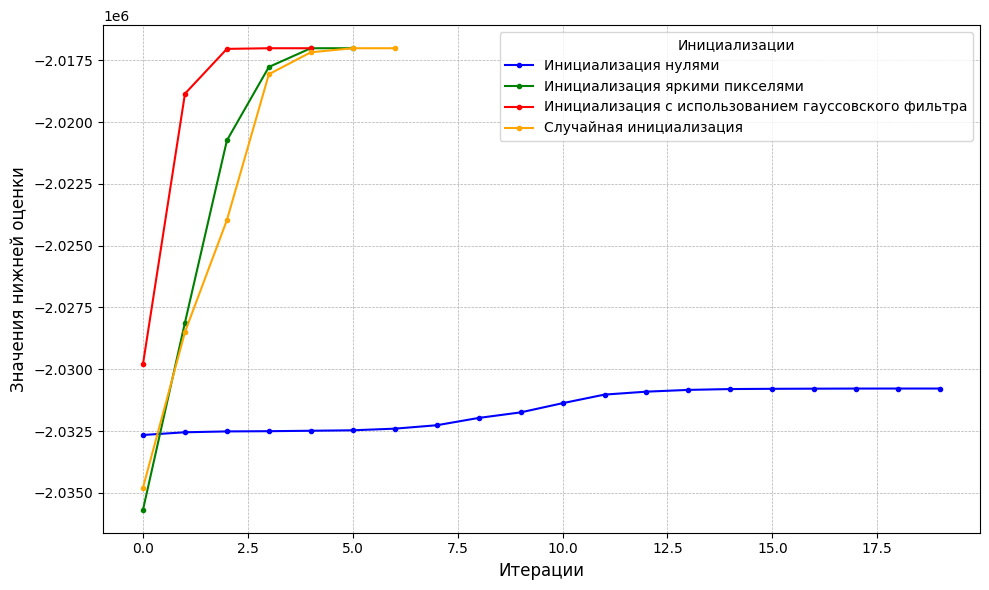

In [44]:
plt.figure(figsize=(10, 6))

plt.plot(LL_pred_zero_map, label='Инициализация нулями', color='blue', linestyle='-', marker='o', markersize=3)
plt.plot(LL_pred_255_map, label='Инициализация яркими пикселями', color='green', linestyle='-', marker='o', markersize=3)
plt.plot(LL_pred_mean_map, label='Инициализация с использованием гауссовского фильтра', color='red', linestyle='-', marker='o', markersize=3)
plt.plot(LL_pred_rand_map, label='Случайная инициализация', color='orange', linestyle='-', marker='o', markersize=3)

plt.xlabel('Итерации', fontsize=12)
plt.ylabel('Значения нижней оценки', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Инициализации', loc='best', fontsize=10)

plt.tight_layout()
plt.show()

- # Нахождение преступника:

In [60]:
h, w = 82, 70

data_1000 = np.load(r'W:\Загрузки\hse_data_1000.npy').astype(np.float64)
data_500 = np.load(r'W:\Загрузки\hse_data_500.npy').astype(np.float64)
data_300 = np.load(r'W:\Загрузки\hse_data_300.npy').astype(np.float64)
data_100 = np.load(r'W:\Загрузки\hse_data_100.npy').astype(np.float64)
data_50 = np.load(r"W:\Загрузки\data_hse_50.npy").astype(np.float64)

H, W = data_1000[..., 10].shape

F_rand = np.random.randint(0, 256, size=(h, w))
B_rand = np.random.randint(0, 256, size=(H, W))
s_rand = 10
A_rand = np.full((H - h + 1, W - w + 1), 1e-7)
A_rand /= A_rand.sum()


F_1000, B_1000, s_1000, A_1000, ll_1000 = model.run_EM(
    data_1000, h, w, use_MAP=False, max_iter=50,
    s=s_rand, F=F_rand, B=B_rand, A=A_rand
)

F_500, B_500, s_500, A_500, ll_500 = model.run_EM(
    data_500, h, w, use_MAP=False, max_iter=50,
    s=s_rand, F=F_rand, B=B_rand, A=A_rand
)

F_300, B_300, s_300, A_300, ll_300 = model.run_EM(
    data_300, h, w, use_MAP=False, max_iter=50,
    s=s_rand, F=F_rand, B=B_rand, A=A_rand
)

F_100, B_100, s_100, A_100, ll_100 = model.run_EM(
    data_100, h, w, use_MAP=False, max_iter=50,
    s=s_rand, F=F_rand, B=B_rand, A=A_rand
)

F_50, B_50, s_50, A_50, ll_50 = model.run_EM(
    data_50, h, w, use_MAP=False, max_iter=50,
    s=s_rand, F=F_rand, B=B_rand, A=A_rand
)



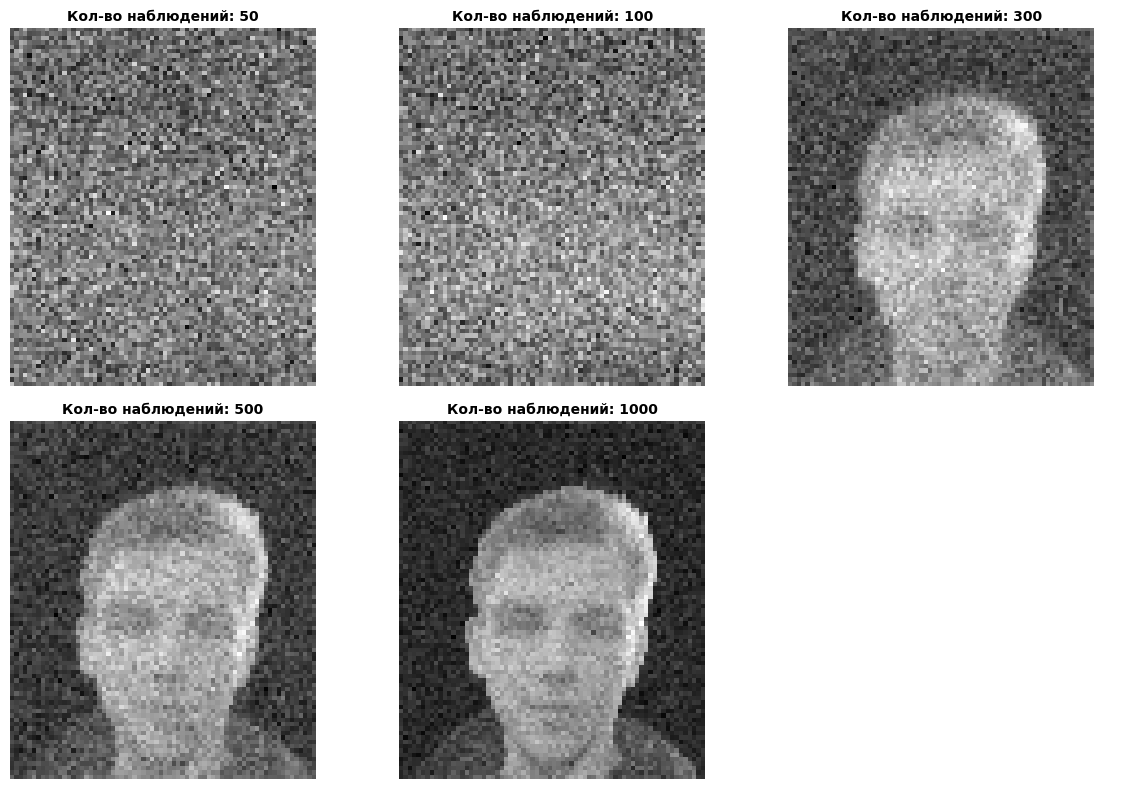

In [71]:
images = {
    "50": F_50,
    "100": F_100,
    "300": F_300,
    "500": F_500,
    "1000": F_1000,
}

n = len(images)
cols = 3
rows = (n + cols - 1) // cols  # Вычисляем количество строк
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

axs = axs.ravel()

for idx, (title, image) in enumerate(images.items()):
    axs[idx].imshow(image, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title(f"Кол-во наблюдений: {title}", fontsize=10, fontweight='bold')

for ax in axs[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


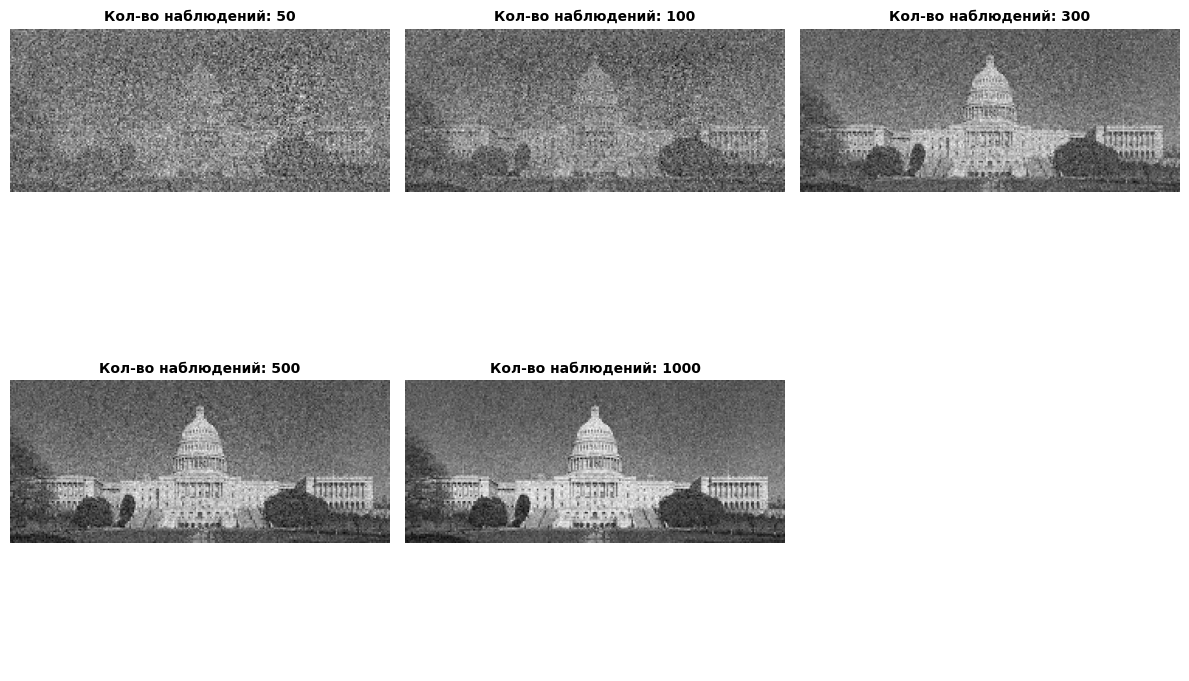

In [72]:
images = {
    "50": B_50,
    "100": B_100,
    "300": B_300,
    "500": B_500,
    "1000": B_1000,
}

n = len(images)
cols = 3
rows = (n + cols - 1) // cols  # Вычисляем количество строк
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

axs = axs.ravel()

for idx, (title, image) in enumerate(images.items()):
    axs[idx].imshow(image, cmap='gray')
    axs[idx].axis('off')
    axs[idx].set_title(f"Кол-во наблюдений: {title}", fontsize=10, fontweight='bold')

for ax in axs[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()